In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras



Import of csv files. Chose between local or google disk/colab

In [2]:
# read data sets 
#groundtruth = pd.read_csv(r'C:\Users\sondr\Downloads\groundtruth.csv')
#crowdsourced = pd.read_csv(r'C:\Users\sondr\Downloads\crowdsourced.csv')
#all_sentences = pd.read_csv(r'C:\Users\sondr\Downloads\all_sentences.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read data sets 
groundtruth = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/groundtruth.csv')
crowdsourced = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crowdsourced.csv')
all_sentences = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all_sentences.csv')

In [5]:
# Combinding data sets
data = pd.concat([groundtruth,crowdsourced],ignore_index=True)
 
 # Add dummist and remove first column. This ensure the remaining olums are linearly independent
result = pd.concat([data, 
                     pd.get_dummies(data['Speaker'], prefix='Speaker_', drop_first=True), 
                     pd.get_dummies(data['Speaker_title'], prefix='Speaker_title_', drop_first=True), 
                     pd.get_dummies(data['Speaker_party'], prefix='Speaker_party_', drop_first=True),
                     pd.get_dummies(data['File_id'], prefix='File_id_', drop_first=True),
                     pd.get_dummies(data['Verdict'], prefix='Verdict')],axis=1)


 

print(result.isna().sum().sort_values(ascending=False))
result = result.dropna(axis=0)
result

Sentiment                    3
Sentence_id                  0
File_id__1980-10-28.txt      0
File_id__1992-10-19.txt      0
File_id__1992-10-15.txt      0
                            ..
Speaker__Richard M. Nixon    0
Speaker__Mitt Romney         0
Speaker__Michael Dukakis     0
Speaker__John McCain         0
Verdict_1                    0
Length: 75, dtype: int64


,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,...,File_id__2008-10-15.txt,File_id__2012-10-03.txt,File_id__2012-10-16.txt,File_id__2012-10-22.txt,File_id__2016-09-26.txt,File_id__2016-10-09.txt,File_id__2016-10-19.txt,Verdict_-1,Verdict_0,Verdict_1
0,26,"You know, I saw a movie - ""Crocodile Dundee.""",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,26,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
1,80,We're consuming 50 percent of the world's coca...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,8,80,-0.740979,1,...,0,0,0,0,0,0,0,0,0,1
2,129,That answer was about as clear as Boston harbor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,129,0.000000,-1,...,0,0,0,0,0,0,0,1,0,0
3,131,Let me help the governor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,5,131,0.212987,-1,...,0,0,0,0,0,0,0,1,0,0
4,172,We've run up more debt in the last eight years...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,22,172,-0.268506,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,34452,You get shot walking to the store.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,7,1331,0.000000,0,...,0,0,0,0,0,0,1,0,1,0
23529,34455,I will do more for African-Americans and Latin...,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,16,1334,0.000000,-1,...,0,0,0,0,0,0,1,1,0,0
23530,34456,All she's done is talk to the African-American...,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,30,1335,0.000000,-1,...,0,0,0,0,0,0,1,1,0,0
23531,34457,"We are going to make America strong again, and...",Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,23,1336,0.812600,-1,...,0,0,0,0,0,0,1,1,0,0


In [6]:
# Define a function to get the sentiment polarity of a text using TextBlob
def get_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the 'get_sentiment_polarity' function to the 'Text' column of the 'result' dataframe.
#Each line in result['Text'] gets a score based on polarity for the given sentence.
result['Sentiment_Polarity2'] = result['Text'].apply(get_sentiment_polarity)
result['Sentiment_Polarity2']

0        0.000000
1        0.000000
2        0.100000
3        0.000000
4        0.250000
           ...   
23528    0.000000
23529    0.500000
23530    0.000000
23531    0.616667
23532    0.500000
Name: Sentiment_Polarity2, Length: 23530, dtype: float64

In [7]:
# Download stopwords and initialize stemmer
nltk.download('punkt')
nltk.download('stopwords')
stopwords = stopwords.words('english')
stemmer = PorterStemmer()

# Define function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words and stem
    processed_tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    # Join tokens back into text
    processed_text = ' '.join(processed_tokens)
    return processed_text

# Apply preprocessing to text column
result['Processed_Text'] = result['Text'].apply(preprocess_text)

print(result['Processed_Text'])

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Convert a collection of raw documents to a matrix of TF-IDF features.
vectorizer.fit(result['Processed_Text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                 know , saw movi - `` crocodil dunde . ''
1                  're consum 50 percent world 's cocain .
2                             answer clear boston harbor .
3                                      let help governor .
4        've run debt last eight year presid georg wash...
                               ...                        
23528                                get shot walk store .
23529            african-american latino ever 10 lifetim .
23530    's done talk african-american latino , get vot...
23531    go make america strong , go make america great...
23532           take four year barack obama , 's get get .
Name: Processed_Text, Length: 23530, dtype: object


TfidfVectorizer()

In [8]:
# Create a CountVectorizer object. max_features is set to 1000 to save comput
vectorizer = CountVectorizer(max_features=1000)

# Fit the CountVectorizer object to the Processed_Text column
X = vectorizer.fit_transform(result['Processed_Text'])

# Convert the result to a pandas dataframe
vectorizer_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
vectorizer_df.head()

,000,10,100,11,12,15,18,20,200,21st,...,worst,worth,would,wrong,ye,year,yet,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
# Download the necessary NLTK data
nltk.download('averaged_perceptron_tagger')

# Define a function to count the number of words belonging to each POS tag
def count_pos_tags(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    pos_tags = nltk.pos_tag(tokens)
    tag_counts = Counter(tag for word, tag in pos_tags)
    return tag_counts

# Apply the function to the 'Text' column
result['POS_tags'] = result['Text'].apply(count_pos_tags)


# Construct a feature for each POS tag
all_tags = set(tag for row in result['POS_tags'] for tag in row.keys())
for tag in all_tags:
    result[tag] = result['POS_tags'].apply(lambda x: x.get(tag, 0))
    result[tag] = result[tag].astype('float32')
   
# Drop the 'POS_tags' column from dataframe "result"
result.drop('POS_tags', axis=1, inplace=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [10]:
result

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict,...,SYM,JJS,FW,NNPS,),WP$,CC,WRB,DT,:
0,26,"You know, I saw a movie - ""Crocodile Dundee.""",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,26,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,80,We're consuming 50 percent of the world's coca...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,8,80,-0.740979,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,129,That answer was about as clear as Boston harbor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,129,0.000000,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,131,Let me help the governor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,5,131,0.212987,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,172,We've run up more debt in the last eight years...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,22,172,-0.268506,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,34452,You get shot walking to the store.,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,7,1331,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23529,34455,I will do more for African-Americans and Latin...,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,16,1334,0.000000,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23530,34456,All she's done is talk to the African-American...,Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,30,1335,0.000000,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0
23531,34457,"We are going to make America strong again, and...",Donald Trump,Businessman,REPUBLICAN,2016-10-19.txt,23,1336,0.812600,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


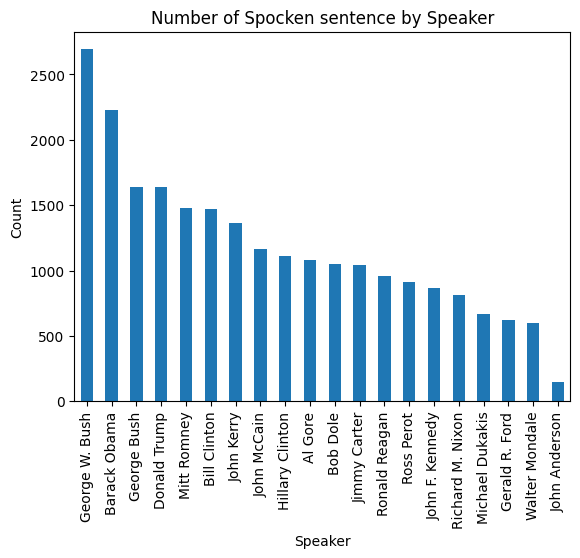

In [11]:
speaker_counts = result['Speaker'].value_counts()

speaker_counts.plot(kind='bar')

# Add axis labels and title
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.title('Number of Spocken sentence by Speaker')
plt.show()


In [12]:
# Concatenate the new dataframe with the result dataframe
result = result.drop(['Text','Sentence_id','Speaker','Speaker_title','Speaker_party','Processed_Text'], axis=1)
result = result.dropna(axis=0)
result_vectorizer_df = pd.concat([result, vectorizer_df], axis=1)
result_vectorizer_df = result_vectorizer_df.dropna(axis=0)
result_vectorizer_df

,File_id,Length,Line_number,Sentiment,Verdict,Speaker__Barack Obama,Speaker__Bill Clinton,Speaker__Bob Dole,Speaker__Donald Trump,Speaker__George Bush,...,worst,worth,would,wrong,ye,year,yet,york,young,zone
0,1988-09-25.txt,9.0,26.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1988-09-25.txt,8.0,80.0,-0.740979,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1988-09-25.txt,9.0,129.0,0.000000,-1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1988-09-25.txt,5.0,131.0,0.212987,-1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1988-09-25.txt,22.0,172.0,-0.268506,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23525,2016-10-19.txt,6.0,1328.0,-0.458800,-1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23526,2016-10-19.txt,10.0,1329.0,0.680800,-1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23527,2016-10-19.txt,6.0,1330.0,-0.624900,-1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23528,2016-10-19.txt,7.0,1331.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Functions

In [13]:
def split_data(df, date_col='File_id', split_date='2012-10-03'):

    # split data based on date_col and split_date
    test = df[df[date_col] >= split_date]
    train = df[df[date_col] < split_date]

    test = test.drop([date_col], axis=1)
    train = train.drop([date_col], axis=1)

    # extract features and targets
    y_test, x_test = test.loc[:, 'Verdict_-1' :'Verdict_1'], test.drop(['Verdict_-1','Verdict_0', 'Verdict_1','Verdict'], axis=1)
    y_train, x_train = train.loc[:, 'Verdict_-1' :'Verdict_1'], train.drop(['Verdict_-1','Verdict_0', 'Verdict_1','Verdict'], axis=1)

    # 1 row, used for simple predictions
    y_test1 = test['Verdict'] 
    y_train1 = train['Verdict'] 

    # convert data types to float32
    for col in x_train.columns:
        x_train[col] = x_train[col].astype('float32')

    for col in x_test.columns:
        x_test[col] = x_test[col].astype('float32')
    
    # Scale data
    scaler = StandardScaler()
    scaler2 = StandardScaler()

    scaler.fit(x_train)
    scaler2.fit(x_test)

    x_train = scaler.transform(x_train) 
    x_test = scaler2.transform(x_test)

    return (y_train, x_train, y_test, x_test, y_test1, y_train1)


In [14]:
def calculatMetrics(y_test, y_pred, label_type='-1,0,1'):

  # select if label is [-1, 0, 1] or [0, 1, 2]
    if label_type == '-1,0,1':
        labels = [-1, 0, 1]
    elif label_type == '0,1,2':
        labels = [0, 1, 2]
    else:
        raise ValueError("Invalid label type. Choose '-1,0,1' or '0,1,2'.")

    # Precision, Recall, F1 score
    p_Avg, R_Avg, F1_Avg, N_A =precision_recall_fscore_support(y_test, y_pred, average='weighted')
    p, r, f1, N_A1 = precision_recall_fscore_support(y_test, y_pred, average=None, labels=labels)

    # Make matrics df
    metrics = pd.DataFrame([np.array([p[0],p[1],p[2],p_Avg,r[0],r[1],r[2],R_Avg,f1[0],f1[1],f1[2],F1_Avg])]
                        ,columns=['p_NFS','p_UFS','p_CFS','p_avg','F1_NFS','F1_UFS','F1_CFS','F1_avg', 'r_NFS','r_US','r_CFS','r_avg'])
    return metrics




def evaluate_model(model, x_test, y_test):
    # Evaluate model
    scores = model.evaluate(x_test, y_test)
    
    # Predict on test data
    pred = model.predict(x_test)
    pred_round = np.round(pred, 0).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_test, pred_round, average='weighted')
    

    return f1,scores, pred_round



def evaluate_model2(model, x_test, y_test):
    # Predict on test data
    y_pred = model.predict(x_test)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return f1, accuracy, conf_matrix

In [15]:
def perform_pca(train,test,x_test, n_components=0.90):

    # Fit PCA to features
    pca = PCA(n_components=n_components)
    pca.fit(train)

    # Transform features to principal components
    new_features = pca.transform(train)
    new_x_test = pca.transform(x_test)

    # Scale new features
    scaler = StandardScaler()
    scaler = StandardScaler()
    scaler.fit(new_features)
    scaler.fit(new_x_test)

    # Create dataframe with reduced features
    df_new_features = pd.DataFrame(new_features, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)])
    pca_x_test = pd.DataFrame(new_x_test, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)])

    # Convert all features to float32
    for col in df_new_features.columns:
        df_new_features[col] = df_new_features[col].astype('float32')

    for col in pca_x_test.columns:
        pca_x_test[col] = pca_x_test[col].astype('float32')

    return df_new_features, pca_x_test


Splitting data into test and training data

In [16]:
# Split of data into y_train, x_train, y_test, x_test, using result
y_train, x_train, y_test, x_test, y_test1, y_train1 = split_data(result)
x_train

array([[-0.7200384 , -1.5431218 ,  0.13121599, ..., -0.30396625,
        -0.5252994 ,  1.1875352 ],
       [-0.7961922 , -1.3665769 , -1.4558778 , ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       [-0.7200384 , -1.2063787 ,  0.13121599, ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       ...,
       [-0.5677308 ,  1.8308473 , -1.2433103 , ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       [ 0.04149956,  1.8341167 ,  0.13121599, ..., -0.30396625,
         0.02798876, -0.3363718 ],
       [ 2.7068825 ,  1.837386  ,  1.837028  , ...,  2.4668088 ,
         2.241141  , -0.3363718 ]], dtype=float32)

In [17]:
# Split of data into y_train_vec, x_train_vec, y_test_vec, x_test_vec, using result_vectorizer_df
y_train_vec, x_train_vec, y_test_vec, x_test_vec, y_test1_vec, y_train1_vec = split_data(result_vectorizer_df)
x_train

array([[-0.7200384 , -1.5431218 ,  0.13121599, ..., -0.30396625,
        -0.5252994 ,  1.1875352 ],
       [-0.7961922 , -1.3665769 , -1.4558778 , ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       [-0.7200384 , -1.2063787 ,  0.13121599, ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       ...,
       [-0.5677308 ,  1.8308473 , -1.2433103 , ..., -0.30396625,
        -0.5252994 , -0.3363718 ],
       [ 0.04149956,  1.8341167 ,  0.13121599, ..., -0.30396625,
         0.02798876, -0.3363718 ],
       [ 2.7068825 ,  1.837386  ,  1.837028  , ...,  2.4668088 ,
         2.241141  , -0.3363718 ]], dtype=float32)

Using PCA metode 

In [18]:
# Using perform_pca to reduce features. 
pca_x_train, pca_x_test = perform_pca(x_train,y_train,x_test)
pca_x_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62
0,-1.517721,-0.763196,-0.823489,-0.033274,-0.612102,-2.408478,-1.048939,-1.589261,-0.284618,3.691925,...,-1.332048,-0.449951,-0.735981,0.502541,-0.214327,-0.950230,-0.523461,0.297653,0.313419,0.063435
1,-1.785216,0.002297,-1.521043,-0.522451,0.392304,-1.492198,1.326991,3.531220,1.032829,-1.026805,...,0.590149,-0.593618,0.669425,-1.061767,0.074296,-0.138308,-0.271606,0.299586,0.166365,0.631481
2,-2.279846,-0.560966,-1.648074,-0.942860,-0.146840,-2.916310,0.292981,-0.694444,1.495933,0.420302,...,-0.773833,-0.144122,0.211701,-0.320764,-0.284260,-0.083919,-0.854108,0.087767,-0.546194,0.599836
3,-2.850149,-0.464871,-1.561348,-1.024541,-0.360097,-3.121668,-0.073539,-0.464271,1.388773,0.371264,...,-0.610228,-0.202143,-0.166555,-0.042752,-0.067618,-0.583316,-0.226832,0.407554,-0.218917,0.204938
4,0.857392,-0.039897,-1.571682,-0.807514,-0.144637,-1.452614,0.865376,3.525862,1.023807,-1.935885,...,-0.660497,3.228714,-0.212893,-0.779959,-2.498174,-2.640355,1.352997,-0.204039,-0.161750,-0.115108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18162,-0.726063,-0.473300,-1.605133,-1.152896,-0.487423,-0.339399,-1.757300,1.665752,-1.226266,0.446029,...,-0.868586,0.067211,0.273363,0.403778,0.291228,0.307719,0.025728,-0.582960,0.777261,-1.251209
18163,-2.919871,-0.563591,-1.728140,-0.982774,0.043546,-0.101428,-1.209844,1.795481,-1.025159,0.578506,...,-0.494923,0.354248,0.053276,0.382281,-0.321287,1.149627,0.155845,-0.356337,0.289476,-0.317315
18164,-1.922029,-0.509689,-1.670777,-0.945499,0.039669,-0.042007,-1.174335,1.512674,-1.067040,0.651517,...,-1.016483,0.759823,0.631550,0.047029,-0.119721,1.801991,0.115508,-0.542084,-0.010289,0.137076
18165,0.102657,-0.228304,-1.121818,-1.991305,-1.471618,-1.306805,-1.328144,7.781527,11.158471,7.714934,...,-1.521508,-1.474061,0.314237,-1.259788,-0.890670,0.668653,0.754730,0.449644,1.552407,-0.417995


In [19]:
pca_x_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62
0,-2.297255,-0.105223,0.023963,0.415271,0.502231,0.419618,0.864411,-0.365940,0.245577,0.156021,...,0.071966,-0.494922,-0.380680,-0.515129,0.059942,-0.834501,0.122565,0.270678,-0.036698,-0.346724
1,-1.588952,0.011792,0.393966,0.229683,0.066782,0.113954,0.007003,-0.064876,0.130672,0.160510,...,0.617034,-0.031822,-0.365677,-0.040124,0.083122,-0.636561,-0.883513,-0.633233,-0.509155,0.395113
2,1.464239,-0.459902,-0.192364,0.515197,0.233662,0.383396,-0.410165,-0.631648,-0.887690,1.925446,...,-1.151042,-0.515659,0.239109,-0.001441,-0.194283,0.275852,-0.229835,0.552373,-0.678835,-0.795101
3,-1.476589,-0.123690,-0.637205,-0.015560,0.316867,-0.288991,0.217855,0.207188,0.311160,0.162131,...,1.070782,-1.037631,0.008697,0.275818,-0.629393,-0.726127,1.930331,-0.829048,-0.053977,-0.862682
4,-1.313841,-0.101098,-0.760158,-0.030446,0.957655,0.157619,0.556467,0.336236,0.425010,-0.108849,...,0.729092,-1.595980,-1.093441,-0.624103,-1.097875,-0.760742,1.483163,-0.519989,-0.003949,-0.772388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5358,-2.383875,0.008842,-0.032476,-0.105788,-0.074727,-0.071788,-0.309482,-0.185429,0.041252,0.021658,...,-0.052195,-0.001033,-0.049601,0.437253,0.276322,-0.082924,-0.107720,-0.046636,0.669974,-0.284566
5359,-0.296958,0.047543,0.052643,-0.287082,-0.438507,-0.116159,-0.931665,-0.372262,-0.128095,-0.900615,...,0.251930,-0.359479,-0.116039,-0.352948,2.496239,3.190438,0.218277,1.060124,2.221266,-0.270104
5360,3.477926,0.237963,0.724374,-0.353160,-1.067462,-0.362019,-1.659740,0.011680,-0.051074,-0.084617,...,-1.109515,0.101924,0.499195,-0.099970,0.939384,0.281720,0.022595,-1.032288,0.364375,0.162943
5361,1.511756,0.160595,0.693008,-0.720699,-1.156549,-0.677570,-1.994431,0.549387,-0.341043,-0.087167,...,0.085630,0.040657,-0.352532,0.298370,0.090330,0.168678,-1.289722,-1.380115,-0.826158,1.366291


ANN model trained on full training set

In [20]:
model = Sequential()
model.add(Dense(256, input_dim=110,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=100, batch_size=25, verbose=1, validation_split=0.2 )

Epoch 1/100
582/582 [==============================] - 8s 4ms/step - loss: 0.7135 - accuracy: 0.7193 - val_loss: 0.6379 - val_accuracy: 0.7518
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.6430 - accuracy: 0.7464 - val_loss: 0.6275 - val_accuracy: 0.7515
Epoch 3/100
582/582 [==============================] - 2s 4ms/step - loss: 0.6231 - accuracy: 0.7536 - val_loss: 0.6320 - val_accuracy: 0.7529
Epoch 4/100
582/582 [==============================] - 2s 4ms/step - loss: 0.6103 - accuracy: 0.7532 - val_loss: 0.6437 - val_accuracy: 0.7556
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.5971 - accuracy: 0.7601 - val_loss: 0.6358 - val_accuracy: 0.7477
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.5847 - accuracy: 0.7666 - val_loss: 0.6519 - val_accuracy: 0.7493
Epoch 7/100
582/582 [==============================] - 2s 3ms/step - loss: 0.5770 - accuracy: 0.7684 - val_loss: 0.6610 - val_accuracy: 0.7452

ANN model - Overfitting on purpose

Epoch 1/500
29/29 [==============================] - 2s 11ms/step - loss: 1.0043 - accuracy: 0.5690 - val_loss: 0.8382 - val_accuracy: 0.6868
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 0.8754 - accuracy: 0.6552 - val_loss: 0.8103 - val_accuracy: 0.6937
Epoch 3/500
29/29 [==============================] - 0s 4ms/step - loss: 0.8389 - accuracy: 0.6691 - val_loss: 0.7726 - val_accuracy: 0.7080
Epoch 4/500
29/29 [==============================] - 0s 4ms/step - loss: 0.8058 - accuracy: 0.6771 - val_loss: 0.7415 - val_accuracy: 0.7174
Epoch 5/500
29/29 [==============================] - 0s 4ms/step - loss: 0.7700 - accuracy: 0.6933 - val_loss: 0.7081 - val_accuracy: 0.7240
Epoch 6/500
29/29 [==============================] - 0s 4ms/step - loss: 0.7524 - accuracy: 0.7015 - val_loss: 0.6876 - val_accuracy: 0.7289
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 0.7386 - accuracy: 0.7103 - val_loss: 0.6772 - val_accuracy: 0.7320
Epoch 8/500


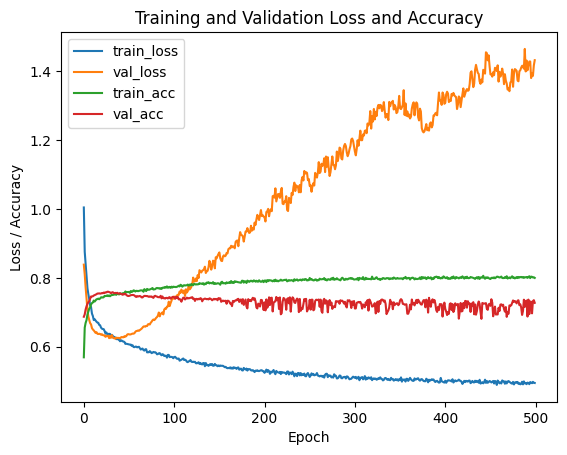

In [21]:
bad_model = Sequential()
bad_model.add(Dense(64, input_dim=110,activation='relu'))
bad_model.add(Dropout(0.5))
bad_model.add(Dense(45, activation='relu'))
bad_model.add(Dropout(0.5))
bad_model.add(Dense(45, activation='relu'))
bad_model.add(Dense(3, activation='softmax'))

bad_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_bad_model = bad_model.fit(x_train, y_train, epochs=500, batch_size=512, verbose=1, validation_split=0.2 )

plt.plot(history_bad_model.history['loss'], label='train_loss')
plt.plot(history_bad_model.history['val_loss'], label='val_loss')
plt.plot(history_bad_model.history['accuracy'], label='train_acc')
plt.plot(history_bad_model.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

ANN model trained on PCA training set

Epoch 1/110
15/15 [==============================] - 2s 17ms/step - loss: 1.6686 - accuracy: 0.2519 - val_loss: 1.0869 - val_accuracy: 0.3897
Epoch 2/110
15/15 [==============================] - 0s 5ms/step - loss: 1.2853 - accuracy: 0.3877 - val_loss: 0.9942 - val_accuracy: 0.6637
Epoch 3/110
15/15 [==============================] - 0s 5ms/step - loss: 1.1178 - accuracy: 0.4926 - val_loss: 0.9466 - val_accuracy: 0.6800
Epoch 4/110
15/15 [==============================] - 0s 5ms/step - loss: 1.0451 - accuracy: 0.5531 - val_loss: 0.9182 - val_accuracy: 0.6811
Epoch 5/110
15/15 [==============================] - 0s 5ms/step - loss: 1.0093 - accuracy: 0.5801 - val_loss: 0.9009 - val_accuracy: 0.6813
Epoch 6/110
15/15 [==============================] - 0s 5ms/step - loss: 0.9759 - accuracy: 0.6061 - val_loss: 0.8892 - val_accuracy: 0.6813
Epoch 7/110
15/15 [==============================] - 0s 5ms/step - loss: 0.9504 - accuracy: 0.6198 - val_loss: 0.8760 - val_accuracy: 0.6813
Epoch 8/110


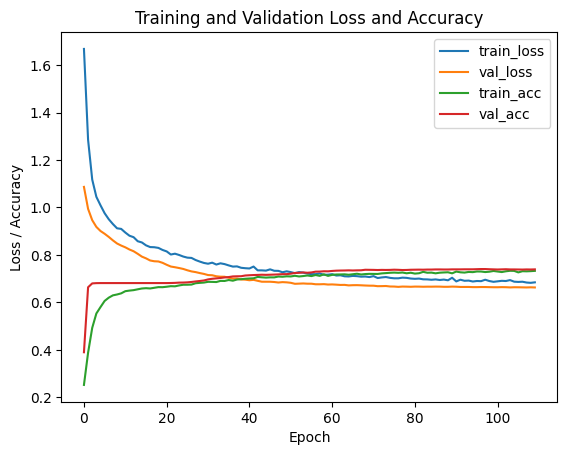

In [22]:
pca_model = Sequential()
pca_model.add(Dense(32, input_dim=62,activation='relu'))
pca_model.add(Dropout(0.5))
pca_model.add(Dense(24, activation='relu'))
pca_model.add(Dropout(0.5))
pca_model.add(Dense(24, activation='relu'))
pca_model.add(Dropout(0.5))
pca_model.add(Dense(3, activation='softmax'))

pca_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_pca_model = pca_model.fit(pca_x_train, y_train, epochs=110, batch_size=1024, verbose=1, validation_split=0.2 )


plt.plot(history_pca_model.history['loss'], label='train_loss')
plt.plot(history_pca_model.history['val_loss'], label='val_loss')
plt.plot(history_pca_model.history['accuracy'], label='train_acc')
plt.plot(history_pca_model.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

ANN model preformens

In [23]:
f1_model, scores_model, MODEL_ANN_predictions  = evaluate_model(model, x_test, y_test)
print("F1 score:", round(f1_model,3))
print("scores:")
print(scores_model)
MODEL_ANN_predictions

168/168 [==============================] - 0s 1ms/step
F1 score: 0.664
scores:
[1.6669455766677856, 0.6841320395469666]


array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [24]:
f1_bad_model, scores_bad_model, BAD_MODEL_ANN_predictions = evaluate_model(bad_model, x_test, y_test)
print("F1 score:", round(f1_bad_model,3))
print("scores:")
print(scores_bad_model)
BAD_MODEL_ANN_predictions

168/168 [==============================] - 0s 1ms/step
F1 score: 0.646
scores:
[0.8193310499191284, 0.6986761093139648]


array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [25]:
f1_pca_model, scores_pca_model, PCA_MODEL_predictions = evaluate_model(pca_model, pca_x_test, y_test)
print("F1 score:", round(f1_pca_model,3))
print("scores:")
print(scores_pca_model)
PCA_MODEL_predictions

168/168 [==============================] - 0s 1ms/step
F1 score: 0.596
scores:
[0.743374764919281, 0.6956927180290222]


array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [26]:
print(pca_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                2016      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 24)                792       
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                

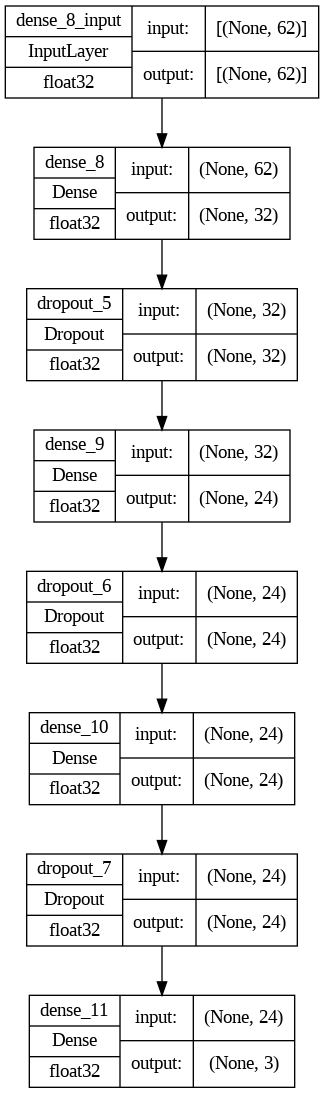

In [27]:
keras.utils.plot_model(pca_model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True,  
                       to_file='pca_model.png')

Simple models

In [28]:
# All 3 models trained on the first data set.

# Support Vector Machine Model
# Train SVM classifier
SVM_clf = LinearSVC()
SVM_clf.fit(x_train, y_train1)
SVM_predictions = SVM_clf.predict(x_test)

# Random Forest Model
# Train a Random Forest classifier
RF_clf = RandomForestClassifier(n_estimators=100, random_state=10)
RF_clf.fit(x_train, y_train1)
RF_predictions = RF_clf.predict(x_test)

# Logistic regression Model
# Train a Logistic regression classifier
LOGIT_clf = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
LOGIT_clf.fit(x_train, y_train1)
LOGIT_predictions = LOGIT_clf.predict(x_test)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


using the pca features and finding optimal parameters

In [29]:
# Define parameters to test
n_estimators = [100, 200, 300]
max_depth = [None, 10, 20]

# Iterate over all combinations of tuning parameters
for n in n_estimators:
    for d in max_depth:
        # Train a Random Forest classifier
        RF_clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=10)
        RF_clf.fit(pca_x_train, y_train1)
        # Evaluate the model and print the results
        f1_model, scores_model, conf_matrix = evaluate_model2(RF_clf, pca_x_test, y_test1)
        print(f"n_estimators = {n}, max_depth = {d}")
        print("F1 score:", round(f1_model,3))
        print("scores:")
        print(scores_model)


n_estimators = 100, max_depth = None
F1 score: 0.593
scores:
0.6720119336192429
n_estimators = 100, max_depth = 10
F1 score: 0.58
scores:
0.6673503636024614
n_estimators = 100, max_depth = 20
F1 score: 0.595
scores:
0.6733171732239418
n_estimators = 200, max_depth = None
F1 score: 0.595
scores:
0.6740630244266269
n_estimators = 200, max_depth = 10
F1 score: 0.579
scores:
0.6666045123997763
n_estimators = 200, max_depth = 20
F1 score: 0.594
scores:
0.6733171732239418
n_estimators = 300, max_depth = None
F1 score: 0.597
scores:
0.6753682640313258
n_estimators = 300, max_depth = 10
F1 score: 0.579
scores:
0.6662315867984338
n_estimators = 300, max_depth = 20
F1 score: 0.597
scores:
0.6749953384299833


We chose following settings:

n_estimators = 200, 
 
max_depth = None

F1 score: 0.598

scores:0.6759276524333395

In [30]:
# Define parameters
C_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
solver_values = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Loop through  values
for C in C_values:
    for solver in solver_values:
        LOGIT_clf = LogisticRegression(C=C, solver=solver, multi_class='ovr', random_state=17, n_jobs=4)
        LOGIT_clf.fit(pca_x_train, y_train1)
        LOGIT_predictions = LOGIT_clf.predict(pca_x_test)
        f1_model, scores_model, conf_matrix = evaluate_model2(LOGIT_clf, pca_x_test, y_test1)
        print("C:", C, "Solver:", solver, "Multi_class:", 'ovr')
        print("F1 score:", round(f1_model,3))
        print("Scores:")
        print(scores_model)
        print("----------")



C: 0.0001 Solver: newton-cg Multi_class: ovr
F1 score: 0.521
Scores:
0.6380757038970726
----------
C: 0.0001 Solver: lbfgs Multi_class: ovr
F1 score: 0.521
Scores:
0.6380757038970726
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 0.0001 Solver: liblinear Multi_class: ovr
F1 score: 0.629
Scores:
0.683945552862204
----------
C: 0.0001 Solver: sag Multi_class: ovr
F1 score: 0.521
Scores:
0.6380757038970726
----------
C: 0.0001 Solver: saga Multi_class: ovr
F1 score: 0.521
Scores:
0.6380757038970726
----------
C: 0.001 Solver: newton-cg Multi_class: ovr
F1 score: 0.606
Scores:
0.6785381316427372
----------
C: 0.001 Solver: lbfgs Multi_class: ovr
F1 score: 0.606
Scores:
0.6785381316427372
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 0.001 Solver: liblinear Multi_class: ovr
F1 score: 0.623
Scores:
0.6859966436695879
----------
C: 0.001 Solver: sag Multi_class: ovr
F1 score: 0.606
Scores:
0.6785381316427372
----------
C: 0.001 Solver: saga Multi_class: ovr
F1 score: 0.606
Scores:
0.6785381316427372
----------
C: 0.01 Solver: newton-cg Multi_class: ovr
F1 score: 0.619
Scores:
0.683945552862204
----------
C: 0.01 Solver: lbfgs Multi_class: ovr
F1 score: 0.619
Scores:
0.683945552862204
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 0.01 Solver: liblinear Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 0.01 Solver: sag Multi_class: ovr
F1 score: 0.619
Scores:
0.683945552862204
----------
C: 0.01 Solver: saga Multi_class: ovr
F1 score: 0.619
Scores:
0.683945552862204
----------
C: 0.1 Solver: newton-cg Multi_class: ovr
F1 score: 0.624
Scores:
0.6871154204736155
----------
C: 0.1 Solver: lbfgs Multi_class: ovr
F1 score: 0.624
Scores:
0.6871154204736155
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 0.1 Solver: liblinear Multi_class: ovr
F1 score: 0.624
Scores:
0.6871154204736155
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 0.1 Solver: sag Multi_class: ovr
F1 score: 0.624
Scores:
0.6871154204736155
----------
C: 0.1 Solver: saga Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 1 Solver: newton-cg Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 1 Solver: lbfgs Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 1 Solver: liblinear Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 1 Solver: sag Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 1 Solver: saga Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 10 Solver: newton-cg Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 10 Solver: lbfgs Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 10 Solver: liblinear Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 10 Solver: sag Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 10 Solver: saga Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 100 Solver: newton-cg Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 100 Solver: lbfgs Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


C: 100 Solver: liblinear Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 100 Solver: sag Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------
C: 100 Solver: saga Multi_class: ovr
F1 score: 0.624
Scores:
0.6869289576729443
----------


We chose following settings:

C: 1

 Solver: lbfgs 
 
 Multi_class: ovr


F1 score: 0.624


Scores:0.6869289576729443

In [31]:
# Support Vector Machine Model
# Train SVM classifier
SVM_clf_PCA = LinearSVC()
SVM_clf_PCA.fit(pca_x_train, y_train1)
SVM_PCA_predictions = SVM_clf_PCA.predict(pca_x_test)

# Random Forest Model
# Train a Random Forest classifier
RF_clf_PCA = RandomForestClassifier(n_estimators=200, random_state=None)
RF_clf_PCA.fit(pca_x_train, y_train1)
RF_PCA_predictions = RF_clf_PCA.predict(pca_x_test)

# Logistic regression Model
# Train a Logistic regression classifier
LOGIT_clf_PCA = LogisticRegression(C=1, solver='lbfgs', multi_class='ovr', random_state=17, n_jobs=4)
LOGIT_clf_PCA.fit(pca_x_train, y_train1)
LOGIT_PCA_predictions = LOGIT_clf_PCA.predict(pca_x_test)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [32]:
f1_SVM_clf_PCA, scores_SVM_clf_PCA, conf_matrix_SVM_clf_PCA = evaluate_model2(SVM_clf_PCA, pca_x_test, y_test1)
print("F1 score:", round(f1_SVM_clf_PCA,3))
print("scores:")
print(scores_SVM_clf_PCA)
conf_matrix_SVM_clf_PCA

F1 score: 0.618
scores:
0.6831997016595189


array([[3170,    4,  140],
       [ 456,    9,  158],
       [ 934,    7,  485]])

In [33]:
f1_RF_clf_PCA, scores_RF_clf_PCA, conf_matrix_RF_clf_PCA = evaluate_model2(RF_clf_PCA, pca_x_test, y_test1)
print("F1 score:", round(f1_RF_clf_PCA,3))
print("scores:")
print(scores_RF_clf_PCA)
conf_matrix_RF_clf_PCA

F1 score: 0.597
scores:
0.6746224128286407


array([[3223,    0,   91],
       [ 513,    2,  108],
       [1031,    2,  393]])

In [34]:
f1_LOGIT_clf_PCA, scores_LOGIT_clf_PCA, conf_matrix_LOGIT_clf_PCA = evaluate_model2(LOGIT_clf_PCA, pca_x_test, y_test1)
print("F1 score:", round(f1_LOGIT_clf_PCA,3))
print("scores:")
print(scores_LOGIT_clf_PCA)
conf_matrix_LOGIT_clf_PCA

F1 score: 0.624
scores:
0.6869289576729443


array([[3156,    2,  156],
       [ 447,    9,  167],
       [ 898,    9,  519]])

Comparing all models

In [35]:
y_test1_vec

48      -1.0
49      -1.0
50       0.0
51      -1.0
52       1.0
        ... 
23525   -1.0
23526   -1.0
23527   -1.0
23528    0.0
23529   -1.0
Name: Verdict, Length: 5360, dtype: float64

In [36]:
len(SVM_PCA_predictions)

5363

In [37]:
# Making plots and metrics
SVM_Metrics = calculatMetrics(y_test1, SVM_predictions, '-1,0,1')
RF_Metrics = calculatMetrics(y_test1, RF_predictions, '-1,0,1')
LOGIT_Metrics = calculatMetrics(y_test1, LOGIT_predictions, '-1,0,1')

SVM_Metrics_pca = calculatMetrics(y_test1, SVM_PCA_predictions, '-1,0,1')
RF_Metrics_pca = calculatMetrics(y_test1, RF_PCA_predictions, '-1,0,1')
LOGIT_Metrics_pca = calculatMetrics(y_test1, LOGIT_PCA_predictions, '-1,0,1')

MODEL_ANN_Metrics = calculatMetrics(y_test, MODEL_ANN_predictions, '0,1,2')
BAD_MODEL_ANN_Metrics = calculatMetrics(y_test, BAD_MODEL_ANN_predictions, '0,1,2')
PCA_MODEL_Metrics = calculatMetrics(y_test, PCA_MODEL_predictions, '0,1,2')
#PCA_MODEL2_Metrics = calculatMetrics(y_test, model3_predictions, '0,1,2')

Metrics = pd.concat([SVM_Metrics,RF_Metrics,LOGIT_Metrics,SVM_Metrics_pca,RF_Metrics_pca,LOGIT_Metrics_pca,MODEL_ANN_Metrics,BAD_MODEL_ANN_Metrics,PCA_MODEL_Metrics])
Metrics = Metrics.set_index(pd.Index(['SVM','RF','LOGIT','SVM_PCA','RF_PCA','LOGIT_PCA', 'MODEL_ANN', 'BAD_MODEL_ANN', 'PCA_MODEL']))

Metrics

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,p_NFS,p_UFS,p_CFS,p_avg,F1_NFS,F1_UFS,F1_CFS,F1_avg,r_NFS,r_US,r_CFS,r_avg
SVM,0.711469,0.642857,0.636073,0.683451,0.947194,0.014446,0.417952,0.698117,0.812581,0.028257,0.504444,0.639536
RF,0.713799,0.495050,0.647196,0.670679,0.949004,0.080257,0.388499,0.699049,0.814767,0.138122,0.485539,0.648623
LOGIT,0.701178,0.450000,0.616390,0.649454,0.952323,0.014446,0.363955,0.686929,0.807678,0.027994,0.457672,0.624039
SVM_PCA,0.695175,0.450000,0.619413,0.646549,0.956548,0.014446,0.340112,0.683200,0.805182,0.027994,0.439113,0.617562
RF_PCA,0.676107,0.500000,0.663851,0.652390,0.972541,0.003210,0.275596,0.674622,0.797674,0.006380,0.389495,0.597219
LOGIT_PCA,0.701178,0.450000,0.616390,0.649454,0.952323,0.014446,0.363955,0.686929,0.807678,0.027994,0.457672,0.624039
MODEL_ANN,0.759674,0.301455,0.620545,0.669450,0.870851,0.232745,0.415147,0.675555,0.811472,0.262681,0.497479,0.664231
BAD_MODEL_ANN,0.746880,0.365591,0.637500,0.673503,0.902836,0.054575,0.393408,0.668842,0.817486,0.094972,0.486557,0.645562
PCA_MODEL,0.765273,0.000000,0.721868,0.664833,0.861798,0.000000,0.238429,0.595935,0.810673,0.000000,0.358461,0.596259
